Name: Aditya Saripalli  
Roll No: 20173071  


In [1]:
import os
import re
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
# Creating complete feature space from training data.
def create_word_vectors(training_data_path):
    #feature space - containing all the distinct words from all the documents
    bag_of_words = set()
    #A dictionary of word vectors with key=filename and
    #value=A Counter Object representing word vector of that file
    d_word_vectors = {}
    # A dictionary with key="class_label" and 
    # value=list of file_indices ("class_label/filename")
    d_class_files = defaultdict(list)
    #get the sub directories list
    dir_list = os.listdir(training_data_path)

    for class_label in dir_list:
        source_dir = training_data_path + "/" + class_label
        file_paths = [ source_dir+"/"+file  for file in os.listdir(source_dir) ]
        #Read the all files and create the feature space
        for file_path in file_paths:
            #ignoring unicode characters while opening the data file
            data_file = open(file_path, "r", encoding='utf-8', errors='ignore')
            word_vector = Counter();
            for line in data_file.readlines():
                #exracting only lower case words
                line_tokens = re.findall(r"\b[A-Za-z][a-z]{2,26}\b", line)
                line_tokens = [token.lower() for token in line_tokens]
                line_tokens = list(set(line_tokens))
                for word in line_tokens: word_vector[word] += 1
                bag_of_words |= set(line_tokens)
            data_file.close()
            file_index = class_label + "/" + file_path.split("/")[-1]
            d_word_vectors[file_index] = word_vector
            d_class_files[class_label].append(file_index)

    return list(bag_of_words), d_word_vectors, d_class_files

In [3]:
def compute_word_freq_vectors(bag_of_words, d_word_vectors):
    #dictionary of word frequency vectors
    d_word_freq_vectors = {}
    for key,value in d_word_vectors.items():
        word_freq_vector = []
        for word in bag_of_words:
            word_freq_vector += [value[word]]
        d_word_freq_vectors[key] = word_freq_vector

    return d_word_freq_vectors

In [4]:
#Creating TF-IDF Matrix
def create_tfidf_matrix(bag_of_words, d_word_freq_vectors):
    #create the term frequency matrix from word frequency vectors
    freq_term_matrix = np.array([])
    file_index_array = np.array([])

    #sort the dictionary on keys
    for key,value in d_word_freq_vectors.items():
        freq_term_matrix = np.array(value) if freq_term_matrix.size == 0 \
                                           else np.vstack((freq_term_matrix, np.array(value)))
        file_index_array = np.array(key) if file_index_array.size == 0 \
                                           else np.vstack((file_index_array, np.array(key)))
    #form the tf-idf matrix
    tfidf = TfidfTransformer(norm="l2")
    tfidf.fit(freq_term_matrix)
    tf_idf_matrix = tfidf.transform(freq_term_matrix)
    
    return tf_idf_matrix, file_index_array

In [5]:
#Applying dimensionality reduction using SVD
def reduce_dimension_using_svd(tf_idf_matrix, red_dim):
    #applying truncated svd on tf-idf matrix
    svd = TruncatedSVD(n_components=red_dim)
    svd_dim_reducer = svd.fit(tf_idf_matrix)
    red_tf_idf_matrix = svd_dim_reducer.transform(tf_idf_matrix)
    
    return red_tf_idf_matrix

In [6]:
#Adding the bias and the class labels to the tf idf matrix
#for ease of computation in perceptron
def add_class_and_bias_data(tf_idf_matrix, file_index_array):
    #get the dimensions of the tfidf matrix
    n_records, n_features = tf_idf_matrix.shape
    #adding the class labels
    tf_idf_matrix = np.insert(tf_idf_matrix, n_features, '0', axis=1)
    for index, file_index in enumerate(file_index_array):
        class_label = file_index[0].split("/")[0]
        tf_idf_matrix[index][n_features] = class_label

    #adding the bias vector
    bias_value = 1
    tf_idf_matrix = np.insert(tf_idf_matrix, 0, bias_value, axis=1)

    return tf_idf_matrix


In [7]:
#separate the training (80%) and test (20%)
def split_data_sets(d_class_files, p_tf_idf, file_index_array):
    test_files_list = []
    p_test_tf_idf = np.array([])
    
    for class_label, file_index_list in d_class_files.items():
        class_file_count = len(file_index_list)
        validation_set_size = int(0.2 * class_file_count)
        test_files_list += file_index_list[:validation_set_size]

    slice_index_list = []
    for index, file_index in enumerate(file_index_array):
        if file_index in test_files_list:
            slice_index_list += [index]

    #create the validation reduced tfidf data set
    p_test_tf_idf = np.take(p_tf_idf, slice_index_list, axis=0)
    p_tf_idf = np.delete(p_tf_idf, slice_index_list, axis=0)
    
    return p_test_tf_idf, p_tf_idf


In [8]:
# Training voted perceptron weights
def train_one_all_vp_weights(training_data_set, weights, class_label):
    # separating features and class labels
    data_set_features = np.array(training_data_set[:,:-1])
    
    #modify class labels for multiclass weight training
    data_set_labels = np.array(training_data_set[:,[-1]])
    for index in range(len(data_set_labels)):
        if data_set_labels[index][0] == class_label:
            data_set_labels[index][0] = 1
        else:
            data_set_labels[index][0] = -1

    #get the dimensions of the data set
    n_datasets, n_features = data_set_features.shape
    # learning rate for perceptron is 1.0
    learning_rate = 1.0
    # arrays to store the list of weight vectors
    t_votes = np.empty((0,1))
    t_weights = np.empty((0,n_features))
    # default vote
    votes = 1.0

    for i in range(n_datasets):
        # calculate the dot product y_t(w_t.x_t)
        if (np.dot(data_set_features[i], weights) * data_set_labels[i]) <= 0:
            # in case of a misclassification add the weight vector to the array
            # of weight vectors and its corresponding votes to array of votes
            t_weights = np.vstack((t_weights, weights))
            t_votes = np.vstack((t_votes, [votes]))
            # create a new weight vector and assign a default vote of 1.0
            weights += learning_rate * data_set_labels[i] * data_set_features[i]
            votes = 1.0
        else:
            # weight vector has survived hence increment the vote
            votes = votes + 1.0

    # if at this point the t_weights array is still empty it means the weight
    # vector supplied was good for the entire training set. Thus we update
    # the t_weights array and its corresponding votes count accordingly
    if t_weights.size == 0:
        t_weights = np.vstack((t_weights, weights))
        t_votes = np.vstack((t_votes, [votes]))

    return weights, votes, t_weights, t_votes

In [9]:
# One vs All Voted Perceptron Algorithm
def one_vs_all_voted_perceptron(training_data_set, validation_data_set, class_labels, num_epochs):
    p_accuracy = np.array([])
    # initialize the weight vector excluding the class label
    n_features = training_data_set.shape[1] - 1
    #dictionary to store class labels and corresponding list of votes & weight vectors
    d_class_vp_classifier = {}

    #loop to choose classifier
    for class_label in class_labels:
        weights = np.zeros(n_features)
        votes = 1.0
        # data structures to store the voted weight vectors and their votes
        vp_weights = np.empty((0, n_features))
        vp_votes = np.empty((0,1))
        # each epochs runs for complete training data set
        for epoch in range(num_epochs):
            weights, votes, t_weights, t_votes = train_one_all_vp_weights(training_data_set, weights, class_label)
            vp_weights = np.insert(vp_weights, vp_weights.shape[0], t_weights, axis=0)
            vp_votes = np.insert(vp_votes, vp_votes.shape[0], t_votes, axis=0)
        else:
            #update the last weight vector and votes before next epoch run
            vp_weights = np.insert(vp_weights, vp_weights.shape[0], weights, axis=0)
            vp_votes = np.insert(vp_votes, vp_votes.shape[0], [votes], axis=0)
        #store the votes and weight vectors against the class label
        d_class_vp_classifier[class_label] = (vp_votes, vp_weights)

    # emptying the variables for reuse
    vp_weights = np.empty((0, n_features))
    vp_votes = np.empty((0,1))

    # Multi class validation to find accuracies
    l_predicted_values = []
    l_expected_values  = []
    for row in validation_data_set:
        d_predicted_values = {}
        for class_label in d_class_vp_classifier:
            inner_product = 0.0
            predicted_value = 0.0
            vp_votes, vp_weights = d_class_vp_classifier[class_label]
            # Calculate the inner product and the predicted value using
            # the complete list of weight vectors and their corresponding votes
            for w_vote, w_vector in zip(vp_votes, vp_weights):
                #predicted_value = predicted_value + (w_vote[0] * np.dot(w_vector, row[:-1]))
                inner_product = np.dot(w_vector, row[:-1])
                if inner_product > 0:
                    predicted_value += w_vote[0]
                else:
                    predicted_value -= w_vote[0]
            #create a dictionary with key=predicted_value and value=class_label
            d_predicted_values[predicted_value] = class_label
        # find the greatest among all the predicted values
        # and find its corresponding class_label
        predicted_value = d_predicted_values[max(d_predicted_values.keys())]
        l_predicted_values.append(predicted_value)
        l_expected_values.append(row[-1])
        
        # computing predictions
        num_correct_predictions = 0.0
        for p_value, e_value in zip(l_predicted_values, l_expected_values):
            if p_value == e_value:
                num_correct_predictions += 1;
        
        #computing prediction accuracies
        vdata_size = validation_data_set.shape[0]
        p_accuracy = np.append(p_accuracy, [(num_correct_predictions / vdata_size)])

    # compute the mean accuracy for the current epoch run
    mean_accuracy = p_accuracy.mean()
    return mean_accuracy

In [10]:
# Plotting Epoch vs Accuracies
def plot_epoch_acc_data(epochs_run_list,
                        mean_accuracies,
                        rate):
    
    plt.title("Latent Semantic Analysis for {}% Reduction".format(rate))
    plt.xlabel("Number of Epochs")
    plt.ylabel("Perceptron Accuracies")

    plt.plot(epochs_run_list,
             mean_accuracies)

    plt.legend()
    plt.show()

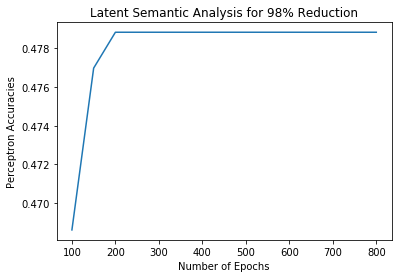

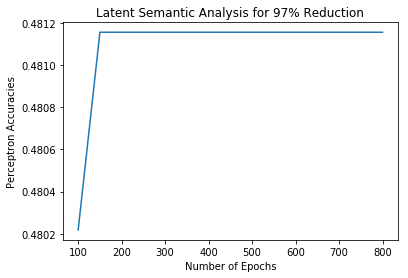

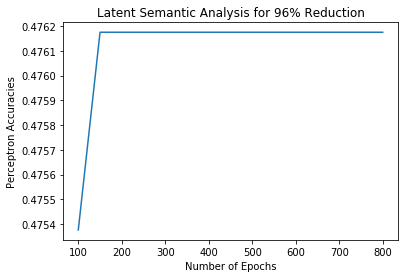

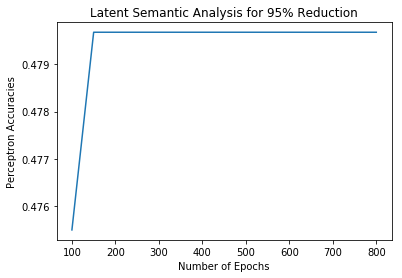

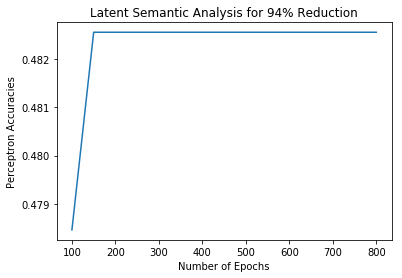

In [11]:
##################################################################################
#               Latent Semantic Analysis - Epoch vs Perceptron Accuracies        #
##################################################################################
# Creating the feature space (Bag of all the words from the corpus)
# and a dictionary of word vectors corresponding to each input file
#bag_of_words, d_word_vectors, d_class_files = create_word_vectors("./test_data")
bag_of_words, d_word_vectors, d_class_files = create_word_vectors("./q2data/train")
class_labels = [float(label) for label in list(d_class_files.keys())]

# compute the word frequency vectors
d_word_freq_vectors = compute_word_freq_vectors(bag_of_words, d_word_vectors)

#create the TF-IDF matrix of the complete data set
tf_idf_matrix, file_index_array = create_tfidf_matrix(bag_of_words, d_word_freq_vectors)

#reduce the dimensionality of the TF-IDF matrix using SVD
n_features = tf_idf_matrix.shape[1]
n_components = tf_idf_matrix.shape[0]
#the list menetions the amount of percentage reduction in the feature space
l_dim_red_percentage = [98, 97, 96, 95, 94]
for rate in l_dim_red_percentage:
    red_dim = int((1 - rate/100) * n_features)
    red_tf_idf_matrix = reduce_dimension_using_svd(tf_idf_matrix, red_dim)

    #add class labels 0-4 at the end of each record in tfidf matrix
    #and bias labels at the begining to prepare the data for perceptron computations
    #p_tf_idf      => perceptron training TF-IDF matrix
    #p_test_tf_idf => perceptron test TF-IDF matrix
    p_tf_idf = add_class_and_bias_data(red_tf_idf_matrix, file_index_array)

    #separate the training (80%) and test (20%)
    p_test_tf_idf, p_tf_idf = split_data_sets(d_class_files, p_tf_idf, file_index_array)

    #apply voted perceptron on the training set
    epochs_run_list = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 700, 800]
    mean_accuracies = []
    for epoch in epochs_run_list:
        mean_accuracy = one_vs_all_voted_perceptron(p_tf_idf, p_test_tf_idf, class_labels, epoch)
        mean_accuracies.append(mean_accuracy)
        #plot the epoch vs accuracies plots
    plot_epoch_acc_data(epochs_run_list, mean_accuracies, rate)


Observations:
=============
-> After running the one vs all voted percptron algorithm on 80% - 20% split data, the perceptron converges after 200 epoch runs - with feature reduction in the range of 94% to 98%.